In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#Loading Data

In [2]:
cancer = pd.read_csv('cancer.csv')

In [3]:
cancer.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,2
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,2
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,2
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,2


In [4]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      569 non-null    float64
 1   V2      569 non-null    float64
 2   V3      569 non-null    float64
 3   V4      569 non-null    float64
 4   V5      569 non-null    float64
 5   V6      569 non-null    float64
 6   V7      569 non-null    float64
 7   V8      569 non-null    float64
 8   V9      569 non-null    float64
 9   V10     569 non-null    float64
 10  V11     569 non-null    float64
 11  V12     569 non-null    float64
 12  V13     569 non-null    float64
 13  V14     569 non-null    float64
 14  V15     569 non-null    float64
 15  V16     569 non-null    float64
 16  V17     569 non-null    float64
 17  V18     569 non-null    float64
 18  V19     569 non-null    float64
 19  V20     569 non-null    float64
 20  V21     569 non-null    float64
 21  V22     569 non-null    float64
 22  V2

In [5]:
cancer['Class'].value_counts()

1    357
2    212
Name: Class, dtype: int64

In [6]:
X = cancer.drop(['Class'],axis=1)

In [7]:
y = cancer['Class']

#Train And Test Splitting

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(455, 30) (114, 30) (455,) (114,)


#Feature Scaling

In [18]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [21]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

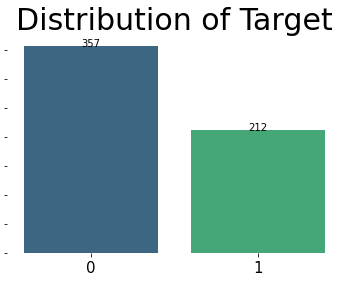

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(y, palette='viridis')
g.set_xticklabels(['0', '1'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Target', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

#Baseline Models

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr,
                            X_train,
                            y_train,
                            cv=5,
                            scoring='roc_auc')
rfc_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [1.         0.97832817 1.         0.99432405 0.99277606]
RFC Scores:  [0.99477534 0.98297214 0.99793602 0.98400413 0.98426213]


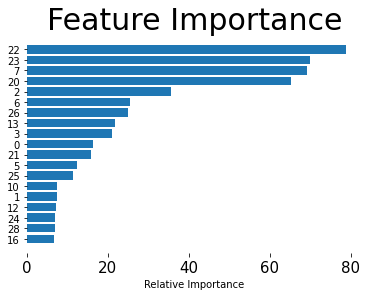

In [23]:
# checking which are the most important features
feature_importance = rfc.fit(X_train, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

#1. Remove features with missing values

In [25]:
# check missing values
X_train.isnull().any().any()

False

#2. Remove features with low variance

In [26]:
from sklearn import feature_selection

sel = feature_selection.VarianceThreshold()
train_variance = sel.fit_transform(X_train)
train_variance.shape

(455, 30)

#3. Remove highly correlated features

In [29]:
# find correlations to target
corr_matrix = cancer.corr().abs()

print(corr_matrix['Class'].sort_values(ascending=False).head(10))

Class    1.000000
V28      0.793566
V23      0.782914
V8       0.776614
V21      0.776454
V3       0.742636
V24      0.733825
V1       0.730029
V4       0.708984
V7       0.696360
Name: Class, dtype: float64


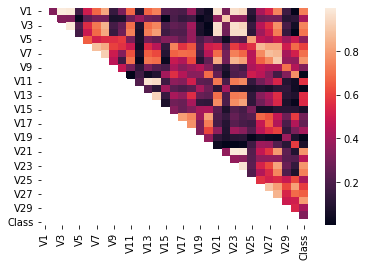

In [30]:
# Select upper triangle of correlation matrix
matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
sns.heatmap(matrix)
plt.show;

In [31]:
# Find index of feature columns with high correlation
to_drop = [column for column in matrix.columns if any(matrix[column] > 0.50)]
print('Columns to drop: ' , (len(to_drop)))

Columns to drop:  25


#4. Univariate Feature Selection

In [33]:
X_train.shape

(455, 30)

In [34]:
# feature extraction
k_best = feature_selection.SelectKBest(score_func=feature_selection.f_classif, k=30)
# fit on train set
fit = k_best.fit(X_train, y_train)
# transform train set
univariate_features = fit.transform(X_train)

In [35]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, univariate_features, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, univariate_features, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [1.         0.97832817 1.         0.99432405 0.99277606]
RFC Scores:  [0.99399164 0.98632611 0.99845201 0.97626419 0.9871001 ]


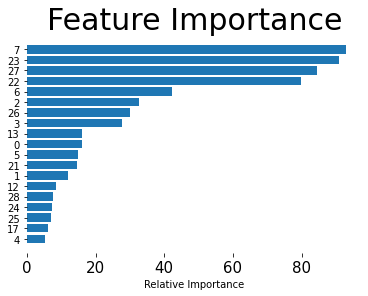

In [37]:
# checking which are the most important features
feature_importance = rfc.fit(univariate_features, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

#5. Recursive Feature Elimination

In [38]:
# feature extraction
rfe = feature_selection.RFE(lr, n_features_to_select=100)

# fit on train set
fit = rfe.fit(X_train, y_train)

# transform train set
recursive_features = fit.transform(X_train)

In [39]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=10)

lr_scores = cross_val_score(lr, recursive_features, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, recursive_features, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [1.         0.97832817 1.         0.99432405 0.99277606]
RFC Scores:  [0.99346917 0.96594427 0.98477812 0.97652219 0.98864809]


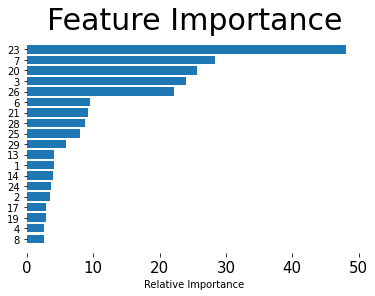

In [40]:
# checking which are the most important features
feature_importance = rfc.fit(recursive_features, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

#6. Feature selection using SelectFromModel

In [41]:
# feature extraction
select_model = feature_selection.SelectFromModel(lr)

# fit on train set
fit = select_model.fit(X_train, y_train)

# transform train set
model_features = fit.transform(X_train)

In [42]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, model_features, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, model_features, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [1.         0.98452012 1.         0.99226006 0.99329205]
RFC Scores:  [0.99059561 0.98297214 0.99793602 0.98426213 0.98684211]


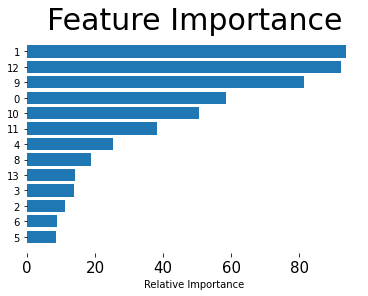

In [44]:
# checking which are the most important features
feature_importance = rfc.fit(model_features, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

#7. PCA

In [54]:
from sklearn.decomposition import PCA
# pca - keep 90% of variance
pca = PCA(0.90)

principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data = principal_components)
principal_df.shape

(455, 7)

In [55]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, principal_df, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, principal_df, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.99947753 0.98090815 0.99896801 0.98813209 0.98916409]
RFC Scores:  [0.99738767 0.98632611 0.99742002 0.98348813 0.98400413]


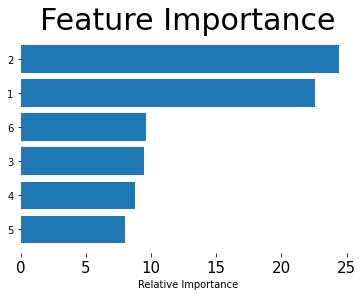

In [56]:
# checking which are the most important features
feature_importance = rfc.fit(principal_df, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

In [47]:
# pca keep 75% of variance
pca = PCA(0.75)
principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data = principal_components)
principal_df.shape

(455, 4)

In [48]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, principal_df, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, principal_df, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.9984326  0.98194014 0.99793602 0.99226006 0.99277606]
RFC Scores:  [0.99529781 0.96852425 0.99742002 0.98219814 0.98194014]


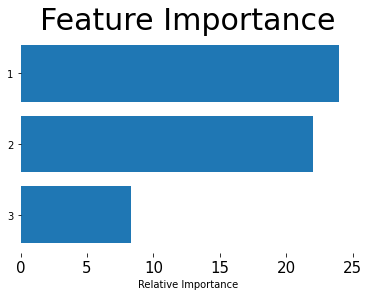

In [49]:
# checking which are the most important features
feature_importance = rfc.fit(principal_df, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()